**Aplicación de proyección de caudales usando el modelo SARIMA**

Referencia: Time Series Forecasting with SARIMA in Python

Link:https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b


In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
data = pd.read_csv('Caudales.csv')
data

,Semana,Caudal
0,22/01/2000,69.30963
1,29/01/2000,59.81791
2,05/02/2000,61.95215
3,12/02/2000,96.10415
4,19/02/2000,253.08719
...,...,...
1078,19/09/2020,27.98657
1079,26/09/2020,25.25900
1080,03/10/2020,25.18557
1081,10/10/2020,33.12600


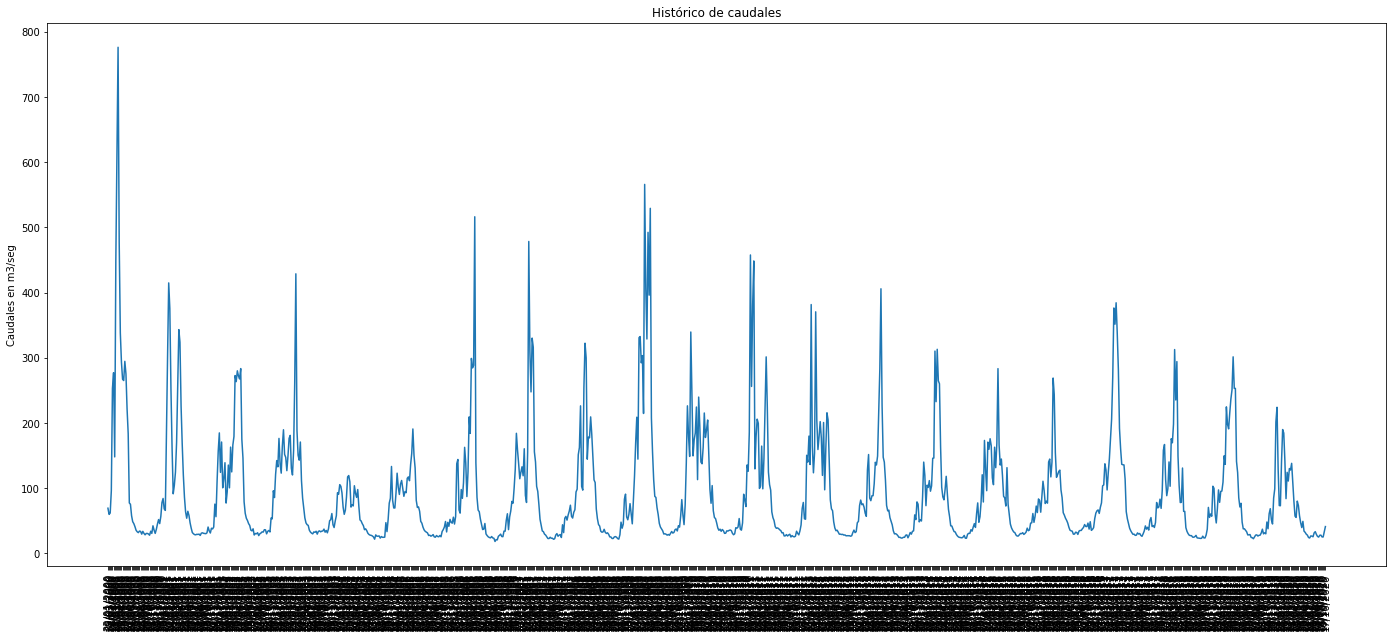

In [ ]:
plt.figure(figsize=[24, 10]); # Set dimensions for figure
plt.plot(data['Semana'], data['Caudal'])
plt.title('Histórico de caudales')
plt.ylabel('Caudales en m3/seg')
plt.xticks(rotation=90)
plt.show()

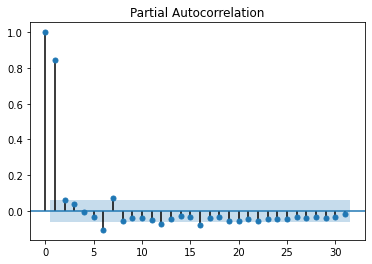

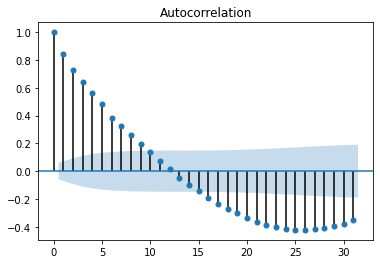

In [ ]:
plot_pacf(data['Caudal']);
plot_acf(data['Caudal']);

In [ ]:
ad_fuller_result = adfuller(data['Caudal'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.806822422679863
p-value: 5.796371692907235e-17


In [ ]:
data['Caudal'] = np.log(data['Caudal'])
data['Caudal'] = data['Caudal'].diff()
data = data.drop(data.index[0])

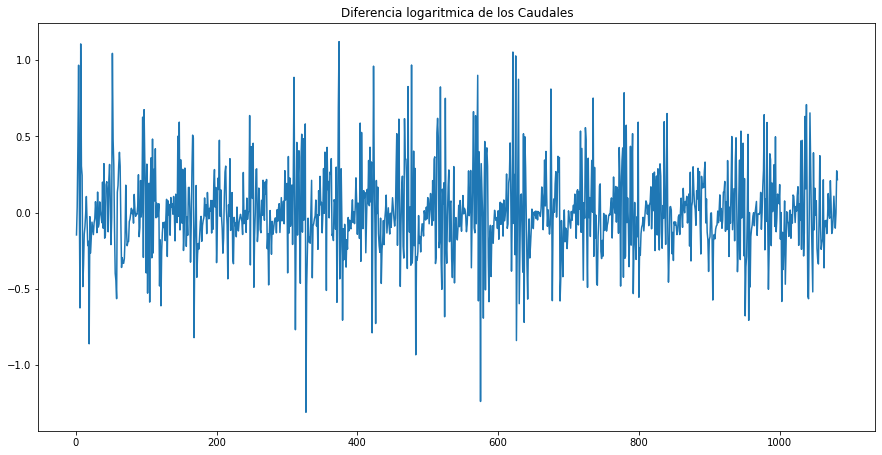

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Caudal'])
plt.title("Diferencia logaritmica de los Caudales")
plt.show()

In [ ]:
# Seasonal differencing
data['Caudal'] = data['Caudal'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)

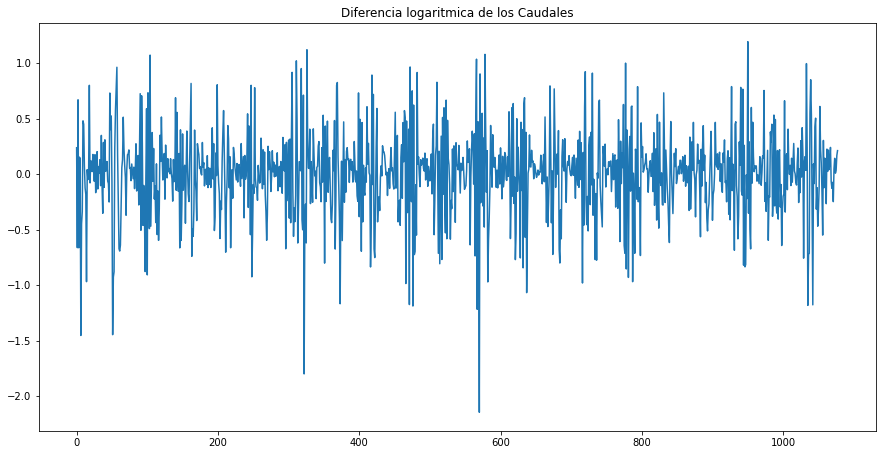

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Caudal'])
plt.title("Diferencia logaritmica de los Caudales")
plt.show()

In [ ]:
ad_fuller_result = adfuller(data['Caudal'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.642742900715232
p-value: 1.505640479883755e-16


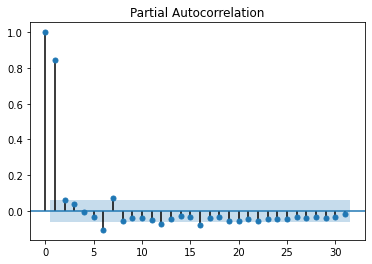

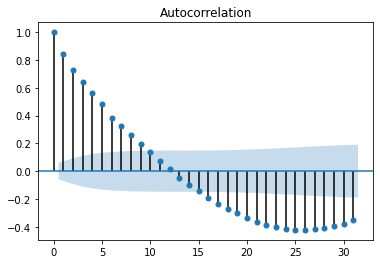

In [ ]:
plot_pacf(data['Caudal']);
plot_acf(data['Caudal']);

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['Caudal'])
result_df

In [ ]:
best_model = SARIMAX(data['Caudal'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)).fit()
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             Caudal   No. Observations:                 1083
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -5424.005
Date:                            Fri, 04 Dec 2020   AIC                          10858.009
Time:                                    07:26:51   BIC                          10882.696
Sample:                                         0   HQIC                         10867.378
                                           - 1083                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6630      0.012     54.821      0.000       0.639       0.687
ma.L1         -0.9992      0.028   

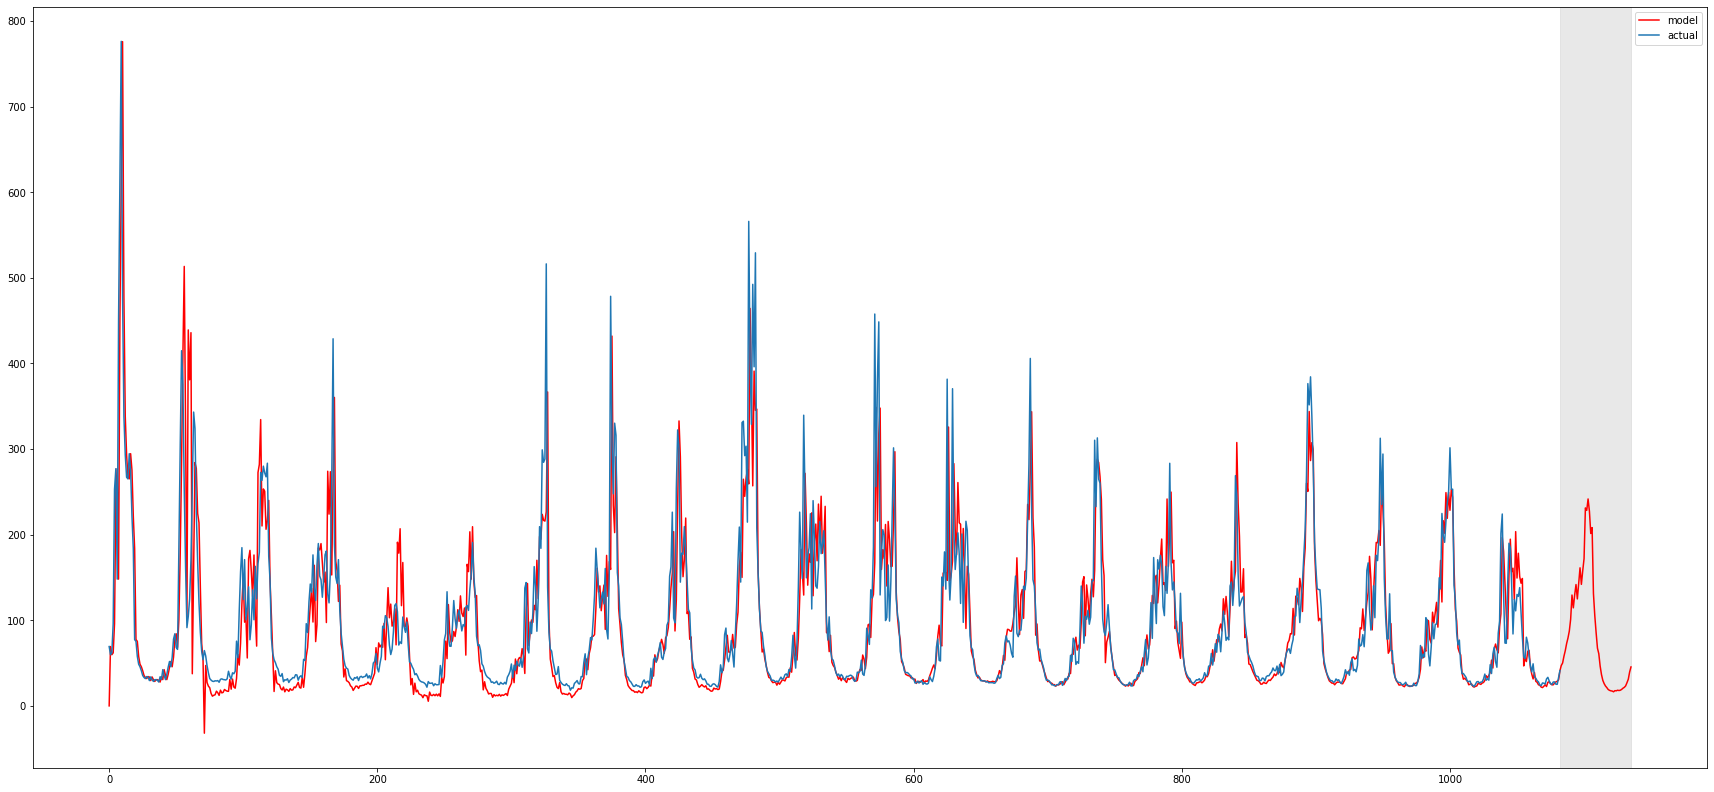

In [ ]:
data['arima_model'] = best_model.fittedvalues
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 52)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(30, 14))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['Caudal'], label='actual')
plt.legend()
plt.show()

In [ ]:
forecast


0        0.000000
1       69.282892
2       59.807470
3       61.943576
4       96.072148
          ...    
1131    23.290724
1132    27.042899
1133    31.147892
1134    39.599334
1135    45.451278
Length: 1136, dtype: float64

In [ ]:
data

,Semana,Caudal,arima_model
0,22/01/2000,69.30963,0.000000
1,29/01/2000,59.81791,69.282892
2,05/02/2000,61.95215,59.807470
3,12/02/2000,96.10415,61.943576
4,19/02/2000,253.08719,96.072148
...,...,...,...
1078,19/09/2020,27.98657,26.539037
1079,26/09/2020,25.25900,28.008313
1080,03/10/2020,25.18557,28.767189
1081,10/10/2020,33.12600,30.267739
